## Inits

In [1]:
import json
import web3
import ipdb
import os

#from web3 import Web3
from web3 import Web3, HTTPProvider
from solc import compile_source
from web3.contract import ConciseContract

import time
import random

## Coops

In [2]:
# Solidity source code
Coops_source_code = '''
pragma solidity ^0.4.24;

//import "./Owned.sol";
//import "./CrowdFunding.sol";

// ----------------------------------------------------------------------------
// 'Coops' token contract
//
// Deployed to : 0xdD870fA1b7C4700F2BD7f44238821C26f7392148
// Symbol      : Coops
// Name        : Coops Token
// Total supply: 100000000
// Decimals    : 18
//
// Enjoy.
//
// (c) by Moritz Neto with BokkyPooBah / Bok Consulting Pty Ltd Au 2017. The MIT Licence.
// ----------------------------------------------------------------------------


// ----------------------------------------------------------------------------
// Safe maths
// ----------------------------------------------------------------------------
contract SafeMath {
    function safeAdd(uint a, uint b) public pure returns (uint c) {
        c = a + b;
        require(c >= a);
    }
    function safeSub(uint a, uint b) public pure returns (uint c) {
        require(b <= a);
        c = a - b;
    }
    function safeMul(uint a, uint b) public pure returns (uint c) {
        c = a * b;
        require(a == 0 || c / a == b);
    }
    function safeDiv(uint a, uint b) public pure returns (uint c) {
        require(b > 0);
        c = a / b;
    }
}


// ----------------------------------------------------------------------------
// ERC Token Standard #20 Interface
// https://github.com/ethereum/EIPs/blob/master/EIPS/eip-20-token-standard.md
// ----------------------------------------------------------------------------
contract ERC20Interface {
    function totalSupply() public constant returns (uint);
    function balanceOf(address tokenOwner) public constant returns (uint balance);
    function allowance(address tokenOwner, address spender) public constant returns (uint remaining);
    function transfer(address to, uint tokens) public returns (bool success);
    function approve(address spender, uint tokens) public returns (bool success);
    function transferFrom(address from, address to, uint tokens) public returns (bool success);

    event Transfer(address indexed from, address indexed to, uint tokens);
    event Approval(address indexed tokenOwner, address indexed spender, uint tokens);
}


// ----------------------------------------------------------------------------
// Contract function to receive approval and execute function in one call
//
// Borrowed from MiniMeToken
// ----------------------------------------------------------------------------
contract ApproveAndCallFallBack {
    function receiveApproval(address from, uint256 tokens, address token, bytes data) public;
}

// ----------------------------------------------------------------------------
// Owned contract
// ----------------------------------------------------------------------------
contract Owned {
    address public owner;
    address public newOwner;

    event OwnershipTransferred(address indexed _from, address indexed _to);

    constructor() public {
        owner = msg.sender;
    }

    modifier onlyOwner {
        require(msg.sender == owner);
        _;
    }

    function transferOwnership(address _newOwner) public onlyOwner {
        newOwner = _newOwner;
    }
    function acceptOwnership() public {
        require(msg.sender == newOwner);
        emit OwnershipTransferred(owner, newOwner);
        owner = newOwner;
        newOwner = address(0);
    }
}

contract CrowdFunding is Owned{
    
    address public beneficiary;
    uint public fundingGoal;
    uint public amountRaised;
    uint public deadline;
    uint numFunders = 0;
    mapping(address => uint256) public balanceOf;
    //mapping(uint => address) Funders;
    //mapping(uint => uint) Funds;
    address[] Funders;
    uint[] Funds;
    bool fundingGoalReached = false;
    bool crowdsaleClosed = true;

    event GoalReached(address recipient, uint totalAmountRaised);
    event FundTransfer(address backer, uint amount, bool isContribution);
    
    address Ccontract = 0x038f160ad632409bfb18582241d9fd88c1a072ba;
    Coops C = Coops(Ccontract);

    /**
     * Constructor function
     *
     * Setup the owner
     */
     
     
    function Crowdsale (
        address _beneficiary,
        uint _fundingGoal,
        uint durationInMinutes
    ) onlyOwner 
      public {
        require(crowdsaleClosed);
        beneficiary = _beneficiary;
        fundingGoal = _fundingGoal;  //InERC20;
        deadline = now + durationInMinutes * 2 seconds;
        crowdsaleClosed = false;
        amountRaised = 0;
        for (uint i = 0; i < numFunders; i++){
            balanceOf[Funders[i]] = 0;
        }
        numFunders = 0;
    }

    /**
     * Fallback function
     *
     * The function without name is the default function that is called whenever anyone sends funds to a contract
     */
    /*  DONATIONS IN ETHER
    function () payable public {
        require(!crowdsaleClosed);
        uint amount = msg.value; 
        balanceOf[msg.sender] += amount;
        amountRaised += amount;
        emit FundTransfer(msg.sender, amount, true);
        //address(this);
    }*/
    
    function receiveFund
    (address _sender,
    uint256 _tokens,
    Coops _tokenContract)
    public{
      require(_tokenContract == C);
      require(!crowdsaleClosed);
      if(amountRaised > fundingGoal) revert();
      require(C.transferFrom(_sender, this, _tokens));
      balanceOf[_sender] += _tokens;
      amountRaised += _tokens;
      //Funders[numFunders] = _sender;
      //Funds[numFunders] = _tokens;
      Funders.push(_sender);
      Funds.push(_tokens);
      numFunders += 1;
      emit FundTransfer(msg.sender, _tokens, true);
    }

    modifier afterDeadline() { if (now >= deadline) _; }

    /**
     * Check if goal was reached
     *
     * Checks if the goal or time limit has been reached and ends the campaign
     */
    function checkGoalReached() public afterDeadline {
        //if (amountRaised >= fundingGoal){
        if (C.balanceOf(this) >= fundingGoal){
            fundingGoalReached = true;
            emit GoalReached(beneficiary, amountRaised);
        }
        crowdsaleClosed = true;
    }


    /**
     * Withdraw the funds
     *
     * Checks to see if goal or time limit has been reached, and if so, and the funding goal was reached,
     * sends the entire amount to the beneficiary. If goal was not reached, each contributor can withdraw
     * the amount they contributed.
     */
    function safeWithdrawal() public afterDeadline {
        if (!fundingGoalReached) {
            uint amount = balanceOf[msg.sender];
            balanceOf[msg.sender] = 0;
            if (amount > 0) {
                if (C.transfer(msg.sender, amount)){
                   emit FundTransfer(msg.sender, amount, false);
                } else {
                    balanceOf[msg.sender] = amount;
                }
            }
        }

        if (fundingGoalReached && beneficiary == msg.sender) {
            if (C.transfer(beneficiary, amountRaised)) {
               emit FundTransfer(beneficiary, amountRaised, false);
                for (uint i = 0; i < numFunders; i++){
                    balanceOf[Funders[i]] = 0;
                }
                C.NewProject(beneficiary,
                    Funders, 
                    Funds, 
                    amountRaised);
            } else {
                //If we fail to send the funds to beneficiary, unlock funders balance
                fundingGoalReached = false;
            }
            //if (C.transfer(beneficiary, amountRaised)) revert();
        }
    }
}




// ----------------------------------------------------------------------------
// ERC20 Token, with the addition of symbol, name and decimals and assisted
// token transfers
// ----------------------------------------------------------------------------



contract Coops is ERC20Interface, Owned, SafeMath {
    
    struct Project{
        address owner;
        address[] funders;
        uint[] amounts;
        uint totalPrice;
        uint ID;
    }
    
    
    string public symbol;
    string public  name;
    
    
    uint8 public decimals;
    uint public _totalSupply;
    
    uint numProjects = 0;
    uint kwh_price = 100;

    mapping(address => uint) balances;
    mapping(address => mapping(address => uint)) allowed;
    mapping(address => mapping(address => uint)) private Debts;
    mapping(address => uint) private totalDebts;
    mapping(uint => Project) private Projects; 

    // ------------------------------------------------------------------------
    // Constructor
    // ------------------------------------------------------------------------
    constructor() public {
        symbol = "Coops";
        name = "Coops Token";
        decimals = 18;
        _totalSupply = 100000000;
        balances[owner] = _totalSupply;
        emit Transfer(address(0), owner, _totalSupply);
    }


    // ------------------------------------------------------------------------
    // Total supply
    // ------------------------------------------------------------------------
    function totalSupply() public constant returns (uint) {
        return _totalSupply  - balances[address(0)];
    }


    // ------------------------------------------------------------------------
    // Get the token balance for account tokenOwner
    // ------------------------------------------------------------------------
    function balanceOf(address tokenOwner) public constant returns (uint balance) {
        return balances[tokenOwner];
    }
    
    function getDebt(address debtor, address creditter) 
    public
    constant
    returns(uint debt)
    {
    return (Debts[debtor][creditter]);
    }
    
    function getTotalDebt(address debtor) 
    public
    constant
    returns(uint debt)
    {
    return (totalDebts[debtor]);
    }


    // ------------------------------------------------------------------------
    // Transfer the balance from token owner's account to to account
    // - Owner's account must have sufficient balance to transfer
    // - 0 value transfers are allowed
    // ------------------------------------------------------------------------
    function transfer(address to, uint tokens) public returns (bool success) {
        balances[msg.sender] = safeSub(balances[msg.sender], tokens);
        balances[to] = safeAdd(balances[to], tokens);
        emit Transfer(msg.sender, to, tokens);
        return true;
    }

    function Pay(address creditter, uint amount) 
    public
    returns(bool success) {
        balances[msg.sender] = safeSub(balances[msg.sender], amount);
        //Debts[debtor][creditter] -= amount;
        Debts[msg.sender][creditter] = safeSub(Debts[msg.sender][creditter],amount);
        //totalDebts[debtor] -= amount;
        totalDebts[msg.sender] = safeSub(totalDebts[msg.sender],amount);
        balances[creditter] = safeAdd(balances[creditter], amount);
        return true;
    } 

    // ------------------------------------------------------------------------
    // Token owner can approve for spender to transferFrom(...) tokens
    // from the token owner's account
    //
    // https://github.com/ethereum/EIPs/blob/master/EIPS/eip-20-token-standard.md
    // recommends that there are no checks for the approval double-spend attack
    // as this should be implemented in user interfaces 
    // ------------------------------------------------------------------------
    function approve(address spender, uint tokens) public returns (bool success) {
        allowed[msg.sender][spender] = tokens;
        emit Approval(msg.sender, spender, tokens);
        return true;
    }
    
    function addDebt(address debtor, address creditter, uint amount) 
    public
    returns(bool success) 
  {
    //Debts[debtor][creditter] += amount;
    Debts[debtor][creditter] = safeAdd(Debts[debtor][creditter], amount);
    //totalDebts[debtor] += amount;
    totalDebts[debtor] = safeAdd(totalDebts[debtor], amount);
    return true;
  }


    // ------------------------------------------------------------------------
    // Transfer tokens from the from account to the to account
    // 
    // The calling account must already have sufficient tokens approve(...)-d
    // for spending from the from account and
    // - From account must have sufficient balance to transfer
    // - Spender must have sufficient allowance to transfer
    // - 0 value transfers are allowed
    // ------------------------------------------------------------------------
    function transferFrom(address from, address to, uint tokens) public returns (bool success) {
        balances[from] = safeSub(balances[from], tokens);
        allowed[from][msg.sender] = safeSub(allowed[from][msg.sender], tokens);
        balances[to] = safeAdd(balances[to], tokens);
        emit Transfer(from, to, tokens);
        return true;
    }

    // ------------------------------------------------------------------------
    // Returns the amount of tokens approved by the owner that can be
    // transferred to the spender's account
    // ------------------------------------------------------------------------
    function allowance(address tokenOwner, address spender) public constant returns (uint remaining) {
        return allowed[tokenOwner][spender];
    }


    // ------------------------------------------------------------------------
    // Token owner can approve for spender to transferFrom(...) tokens
    // from the token owner's account. The spender contract function
    // receiveApproval(...) is then executed
    // ------------------------------------------------------------------------
    /*function approveAndCall(address spender, uint tokens, bytes data) public returns (bool success) {
        allowed[msg.sender][spender] = tokens;
        emit Approval(msg.sender, spender, tokens);
        ApproveAndCallFallBack(spender).receiveApproval(msg.sender, tokens, this, data);
        return true;
    }*/
    function Fund(address spender, uint tokens) public returns (bool success) {
        allowed[msg.sender][spender] = tokens;
        emit Approval(msg.sender, spender, tokens);
        //ApproveAndCallFallBack(spender).receiveApproval(msg.sender, tokens, this, data);
        //CrowdFunding F = CrowdFunding(Fcontract)
        CrowdFunding(spender).receiveFund(
            msg.sender, 
            tokens, 
            this);
        return true;
    }


    // ------------------------------------------------------------------------
    // Don't accept ETH
    // ------------------------------------------------------------------------
    function () public payable {
        revert();
    }


    // ------------------------------------------------------------------------
    // Owner can transfer out any accidentally sent ERC20 tokens
    // ------------------------------------------------------------------------
    function transferAnyERC20Token(address tokenAddress, uint tokens) public onlyOwner returns (bool success) {
        return ERC20Interface(tokenAddress).transfer(owner, tokens);
    }
    
    // ------------------------------------------------------------------------
    // Projects
    // ------------------------------------------------------------------------
    function NewProject(
        address owner,
        address[] funders, 
        uint[] amounts, 
        uint totalPrice) 
        public {
        //require(canCreate[msg.sender] == true);
        //require(D.getTotalDebt(owner) == 0);
        Projects[numProjects].owner = owner;
        Projects[numProjects].funders = funders;
        Projects[numProjects].amounts = amounts;
        Projects[numProjects].totalPrice = totalPrice;
        Projects[numProjects].ID = numProjects;
        numProjects += 1;
    }
    
    function Generate(uint kwh, uint ID) 
      public 
      {
        require(Projects[ID].owner == msg.sender);
        uint amount = kwh*kwh_price;
        uint amount_i;
        for (uint i = 0; i < (Projects[ID].funders).length; i++){
          amount_i = amount*(Projects[ID].amounts[i])/(Projects[ID].totalPrice);
          addDebt(msg.sender, (Projects[ID].funders[i]), amount_i);
        }
    }
}

'''



## Propietarios

In [3]:
# Solidity source code
Propietarios_source_code = '''

pragma solidity ^0.4.24;

//import "./Owned.sol";

// ----------------------------------------------------------------------------
// Owned contract
// ----------------------------------------------------------------------------

contract Propietarios{

  struct Demand {
    uint maxPrice;
    bool Funding;
    uint index;
  }
  /*address Ccontract = 0x23e1bB98a277fd0e974bafC7bB31b5fBfC8CF358;
  Coops C = Coops(Ccontract);*/
  mapping(address => Demand) private Demands;
  address[] private DemandIndex;
  
  mapping(address => int) private Scores;
  mapping(address => mapping(address => bool)) canRate;

  event LogNewDemand   (address indexed userAddress, uint index, bool Funding, uint maxPrice);
  event LogUpdateDemand(address indexed userAddress, uint index, bool Funding, uint maxPrice);
  event LogDeleteDemand(address indexed userAddress, uint index);
  event LogNewRate(address indexed Rated, int Score);
  
  modifier onlyBy(address _account)
  {
    require(
        msg.sender == _account,
        "Sender not authorized."
    );
    // Do not forget the "_;"! It will
    // be replaced by the actual function
    // body when the modifier is used.
    _;
  }
  
  function isDemand(address userAddress)
    public 
    constant
    returns(bool isIndeed) 
  {
    if(DemandIndex.length == 0) return false;
    return (DemandIndex[Demands[userAddress].index] == userAddress);
  }

  function newDemand(
    bool    Funding, 
    uint    maxPrice) 
    public
    returns(uint index)
  {
    if(isDemand(msg.sender)) revert(); 
    Demands[msg.sender].Funding = Funding;
    Demands[msg.sender].maxPrice   = maxPrice;
    Demands[msg.sender].index     = DemandIndex.push(msg.sender)-1;
    emit 
        LogNewDemand(
        msg.sender, 
        Demands[msg.sender].index, 
        Funding, 
        maxPrice);
    return DemandIndex.length-1;
  }

  function deleteDemand(address userAddress) 
    public
    returns(uint index)
  {
    if(!isDemand(userAddress)) revert(); 
    uint rowToDelete = Demands[userAddress].index;
    address keyToMove = DemandIndex[DemandIndex.length-1];
    DemandIndex[rowToDelete] = keyToMove;
    Demands[keyToMove].index = rowToDelete; 
    DemandIndex.length--;
    emit
    LogDeleteDemand(
        userAddress, 
        rowToDelete);
    emit
    LogUpdateDemand(
        keyToMove, 
        rowToDelete, 
        Demands[keyToMove].Funding, 
        Demands[keyToMove].maxPrice);
    return rowToDelete;
  }
  
  function getDemand(address userAddress)
    public 
    constant
    returns(bool Funding, uint maxPrice)
  {
    if(!isDemand(userAddress)) revert(); 
    return(
      Demands[userAddress].Funding, 
      Demands[userAddress].maxPrice); 
      //Demands[userAddress].index);
  } 
  
  function updateFunding(bool Funding) 
    public
    returns(bool success) 
  {
    if(!isDemand(msg.sender)) revert(); 
    Demands[msg.sender].Funding = Funding;
    emit
    LogUpdateDemand(
      msg.sender, 
      Demands[msg.sender].index,
      Funding, 
      Demands[msg.sender].maxPrice);
    return true;
  }
  
  function updatemaxPrice(uint maxPrice) 
    public
    returns(bool success) 
  {
    if(!isDemand(msg.sender)) revert(); 
    Demands[msg.sender].maxPrice = maxPrice;
    emit
    LogUpdateDemand(
      msg.sender, 
      Demands[msg.sender].index,
      Demands[msg.sender].Funding, 
      maxPrice);
    return true;
  }

  function getUserCount() 
    public
    constant
    returns(uint count)
  {
    return DemandIndex.length;
  }

  function getUserAtIndex(uint index)
    public
    constant
    returns(address userAddress)
  {
    return DemandIndex[index];
  }


  function getScore(address Owner)
    public
    constant
    returns(int score)
  {
    return Scores[Owner];
  }

  function allowRating(
    address    rater, 
    address    rated) 
    public
    returns(bool success)
  {
    canRate[rater][rated] = true;
    return true;
  }
  
  function Rate(
    address    rated,
    int       score)
    public
    returns(bool success)
  {
    if (!canRate[msg.sender][rated]) revert();
    if (score < -1) revert();
    if (score > 1) revert();
    Scores[rated] += score;
    canRate[msg.sender][rated] = false;
    emit 
        LogNewRate(
        rated, 
        score);
    return true;
  }  

}

'''

## Proveedores

In [4]:
# Solidity source code
Proveedores_source_code = '''

pragma solidity ^0.4.24;

//import "./Owned.sol";

contract Proveedores{

  struct Provider {
    uint Price;
    uint index;
  }
  
  mapping(address => Provider) private Providers;
  address[] private ProviderIndex;

  mapping(address => int) private Scores;
  mapping(address => mapping(address => bool)) canRate;
  
  event LogNewProvider   (address indexed userAddress, uint index, uint maxPrice);
  event LogUpdateProvider(address indexed userAddress, uint index, uint maxPrice);
  event LogDeleteProvider(address indexed userAddress, uint index);
  event LogNewRate(address indexed Rated, int Score);
  
  function isProvider(address userAddress)
    public 
    constant
    returns(bool isIndeed) 
  {
    if(ProviderIndex.length == 0) return false;
    return (ProviderIndex[Providers[userAddress].index] == userAddress);
  }

  function newProvider(uint Price) 
    public
    returns(uint index)
  {
    if(isProvider(msg.sender)) revert(); 
    Providers[msg.sender].Price   = Price;
    Providers[msg.sender].index     = ProviderIndex.push(msg.sender)-1;
    emit 
        LogNewProvider(
        msg.sender, 
        Providers[msg.sender].index, 
        Price);
    return ProviderIndex.length-1;
  }

  function deleteProvider(address userAddress) 
    public
    returns(uint index)
  {
    if(!isProvider(userAddress)) revert(); 
    uint rowToDelete = Providers[userAddress].index;
    address keyToMove = ProviderIndex[ProviderIndex.length-1];
    ProviderIndex[rowToDelete] = keyToMove;
    Providers[keyToMove].index = rowToDelete; 
    ProviderIndex.length--;
    emit
    LogDeleteProvider(
        userAddress, 
        rowToDelete);
    emit
    LogUpdateProvider(
        keyToMove, 
        rowToDelete, 
        Providers[keyToMove].Price);
    return rowToDelete;
  }
  
  function getProvider(address userAddress)
    public 
    constant
    returns(uint maxPrice)
  {
    if(!isProvider(userAddress)) revert(); 
    return(
      Providers[userAddress].Price); 
      //Providers[userAddress].index);
  } 
  
  function updatePrice(uint newPrice) 
    public
    returns(bool success) 
  {
    if(!isProvider(msg.sender)) revert(); 
    Providers[msg.sender].Price = newPrice;
    emit
    LogUpdateProvider(
      msg.sender, 
      Providers[msg.sender].index,
      newPrice);
    return true;
  }

  function getProvidersCount() 
    public
    constant
    returns(uint count)
  {
    return ProviderIndex.length;
  }

  function getProviderAtIndex(uint index)
    public
    constant
    returns(address userAddress)
  {
    return ProviderIndex[index];
  }
  
  function getScore(address vendor)
    public
    constant
    returns(int score)
  {
    return Scores[vendor];
  }

  function allowRating(
    address    rater, 
    address    rated) 
    public
    returns(bool success)
  {
    canRate[rater][rated] = true;
    return true;
  }
  
  function Rate(
    address    rated,
    int       score)
    public
    returns(bool success)
  {
    if (!canRate[msg.sender][rated]) revert();
    if (score < -1) revert();
    if (score > 1) revert();
    Scores[rated] += score;
    canRate[msg.sender][rated] = false;
    emit 
        LogNewRate(
        rated, 
        score);
    return true;
  }   

}
'''

## Instaladores

In [5]:
# Solidity source code
Instaladores_source_code = '''

pragma solidity ^0.4.24;

//import "./Owned.sol";

contract Instaladores{

  struct Installer {
    uint Price;
    uint index;
  }
  
  mapping(address => Installer) private Installers;
  address[] private InstallerIndex;

  mapping(address => int) private Scores;
  mapping(address => mapping(address => bool)) canRate;
  
  event LogNewInstaller   (address indexed userAddress, uint index, uint maxPrice);
  event LogUpdateInstaller(address indexed userAddress, uint index, uint maxPrice);
  event LogDeleteInstaller(address indexed userAddress, uint index);
  event LogNewRate(address indexed Rated, int Score);
  
  function isInstaller(address userAddress)
    public 
    constant
    returns(bool isIndeed) 
  {
    if(InstallerIndex.length == 0) return false;
    return (InstallerIndex[Installers[userAddress].index] == userAddress);
  }

  function newInstaller(
    uint    Price) 
    public
    returns(uint index)
  {
    if(isInstaller(msg.sender)) revert(); 
    Installers[msg.sender].Price   = Price;
    Installers[msg.sender].index     = InstallerIndex.push(msg.sender)-1;
    emit 
        LogNewInstaller(
        msg.sender, 
        Installers[msg.sender].index, 
        Price);
    return InstallerIndex.length-1;
  }

  function deleteInstaller(address userAddress) 
    public
    returns(uint index)
  {
    if(!isInstaller(userAddress)) revert(); 
    uint rowToDelete = Installers[userAddress].index;
    address keyToMove = InstallerIndex[InstallerIndex.length-1];
    InstallerIndex[rowToDelete] = keyToMove;
    Installers[keyToMove].index = rowToDelete; 
    InstallerIndex.length--;
    emit
    LogDeleteInstaller(
        userAddress, 
        rowToDelete);
    emit
    LogUpdateInstaller(
        keyToMove, 
        rowToDelete, 
        Installers[keyToMove].Price);
    return rowToDelete;
  }
  
  function getInstaller(address userAddress)
    public 
    constant
    returns(uint maxPrice)
  {
    if(!isInstaller(userAddress)) revert(); 
    return(Installers[userAddress].Price);
      //Installers[userAddress].index);
  } 
  
  function updatePrice(uint newPrice) 
    public
    returns(bool success) 
  {
    if(!isInstaller(msg.sender)) revert(); 
    Installers[msg.sender].Price = newPrice;
    emit
    LogUpdateInstaller(
      msg.sender, 
      Installers[msg.sender].index,
      newPrice);
    return true;
  }

  function getInstallersCount() 
    public
    constant
    returns(uint count)
  {
    return InstallerIndex.length;
  }

  function getInstallerAtIndex(uint index)
    public
    constant
    returns(address userAddress)
  {
    return InstallerIndex[index];
  }

  function getScore(address installer)
    public
    constant
    returns(int score)
  {
    return Scores[installer];
  }

  function allowRating(
    address    rater, 
    address    rated) 
    public
    returns(bool success)
  {
    canRate[rater][rated] = true;
    return true;
  }
  
  function Rate(
    address    rated,
    int       score)
    public
    returns(bool success)
  {
    if (!canRate[msg.sender][rated]) revert();
    if (score < -1) revert();
    if (score > 1) revert();
    Scores[rated] += score;
    canRate[msg.sender][rated] = false;
    emit 
        LogNewRate(
        rated, 
        score);
    return true;
  }  

}

'''

## Gestores

In [6]:
# Solidity source code
Gestores_source_code = '''

pragma solidity ^0.4.24;

//import "./Owned.sol";

contract Gestores{

  struct Manager {
    uint Price;
    uint index;
  }
  
  mapping(address => Manager) private Managers;
  address[] private ManagerIndex;
  
  mapping(address => int) private Scores;
  mapping(address => mapping(address => bool)) canRate;

  event LogNewManager   (address indexed userAddress, uint index, uint maxPrice);
  event LogUpdateManager(address indexed userAddress, uint index, uint maxPrice);
  event LogDeleteManager(address indexed userAddress, uint index);
  event LogNewRate(address indexed Rated, int Score);
  
  function isManager(address userAddress)
    public 
    constant
    returns(bool isIndeed) 
  {
    if(ManagerIndex.length == 0) return false;
    return (ManagerIndex[Managers[userAddress].index] == userAddress);
  }

  function newManager(
    uint    Price) 
    public
    returns(uint index)
  {
    if(isManager(msg.sender)) revert(); 
    Managers[msg.sender].Price   = Price;
    Managers[msg.sender].index     = ManagerIndex.push(msg.sender)-1;
    emit 
        LogNewManager(
        msg.sender, 
        Managers[msg.sender].index, 
        Price);
    return ManagerIndex.length-1;
  }

  function deleteManager(address userAddress) 
    public
    returns(uint index)
  {
    if(!isManager(userAddress)) revert(); 
    uint rowToDelete = Managers[userAddress].index;
    address keyToMove = ManagerIndex[ManagerIndex.length-1];
    ManagerIndex[rowToDelete] = keyToMove;
    Managers[keyToMove].index = rowToDelete; 
    ManagerIndex.length--;
    emit
    LogDeleteManager(
        userAddress, 
        rowToDelete);
    emit
    LogUpdateManager(
        keyToMove, 
        rowToDelete, 
        Managers[keyToMove].Price);
    return rowToDelete;
  }
  
  function getManager(address userAddress)
    public 
    constant
    returns(uint Price)
  {
    if(!isManager(userAddress)) revert(); 
    return(
      Managers[userAddress].Price); 
      //Managers[userAddress].index);
  } 
  
  function updatePrice(uint newPrice) 
    public
    returns(bool success) 
  {
    if(!isManager(msg.sender)) revert(); 
    Managers[msg.sender].Price = newPrice;
    emit
    LogUpdateManager(
      msg.sender, 
      Managers[msg.sender].index,
      newPrice);
    return true;
  }

  function getManagersCount() 
    public
    constant
    returns(uint count)
  {
    return ManagerIndex.length;
  }

  function getManagerAtIndex(uint index)
    public
    constant
    returns(address userAddress)
  {
    return ManagerIndex[index];
  }

  function getScore(address manager)
    public
    constant
    returns(int score)
  {
    return Scores[manager];
  }

  function allowRating(
    address    rater, 
    address    rated) 
    public
    returns(bool success)
  {
    canRate[rater][rated] = true;
    return true;
  }
  
  function Rate(
    address    rated,
    int       score)
    public
    returns(bool success)
  {
    if (!canRate[msg.sender][rated]) revert();
    if (score < -1) revert();
    if (score > 1) revert();
    Scores[rated] += score;
    canRate[msg.sender][rated] = false;
    emit 
        LogNewRate(
        rated, 
        score);
    return true;
  }  
}
'''



## Deploy

In [7]:
Coops_compiled_sol = compile_source(Coops_source_code,  import_remappings=['-']) # Compiled source code
Propietarios_compiled_sol = compile_source(Propietarios_source_code,  import_remappings=['=/Users/mimac/PycharmProjects/memoria/','=./', '-']) # Compiled source code
Proveedores_compiled_sol = compile_source(Proveedores_source_code,  import_remappings=['=/Users/mimac/PycharmProjects/memoria/','=./', '-']) # Compiled source code
Instaladores_compiled_sol = compile_source(Instaladores_source_code,  import_remappings=['=/Users/mimac/PycharmProjects/memoria/','=./', '-']) # Compiled source code
Gestores_compiled_sol = compile_source(Gestores_source_code,  import_remappings=['='+os.getcwd(),'=./', '-']) # Compiled source code

Coops_interface = Coops_compiled_sol['<stdin>:Coops']
Propietarios_interface = Propietarios_compiled_sol['<stdin>:Propietarios']
Proveedores_interface = Proveedores_compiled_sol['<stdin>:Proveedores']
Instaladores_interface = Instaladores_compiled_sol['<stdin>:Instaladores']
Gestores_interface = Gestores_compiled_sol['<stdin>:Gestores']

# web3.py instance
w3 = Web3(HTTPProvider('http://localhost:8545'))

# set pre-funded account as sender
w3.eth.defaultAccount = w3.eth.accounts[0]

# Instantiate and deploy contract
Coops = w3.eth.contract(abi=Coops_interface['abi'], bytecode=Coops_interface['bin'])
Propietarios = w3.eth.contract(abi=Propietarios_interface['abi'], bytecode=Propietarios_interface['bin'])
Proveedores = w3.eth.contract(abi=Proveedores_interface['abi'], bytecode=Proveedores_interface['bin'])
Instaladores = w3.eth.contract(abi=Instaladores_interface['abi'], bytecode=Instaladores_interface['bin'])
Gestores = w3.eth.contract(abi=Gestores_interface['abi'], bytecode=Gestores_interface['bin'])

#==========================================================================

# Submit the transaction that deploys the contract
tx_hash = Coops.constructor().transact()

# Wait for the transaction to be mined, and get the transaction receipt
tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)

# Create the contract instance with the newly-deployed address
coops = w3.eth.contract(
    address = tx_receipt.contractAddress,
    abi = Coops_interface['abi'],
)

#==========================================================================

# Submit the transaction that deploys the contract
tx_hash = Propietarios.constructor().transact()

# Wait for the transaction to be mined, and get the transaction receipt
tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)

# Create the contract instance with the newly-deployed address
propietarios = w3.eth.contract(
    address = tx_receipt.contractAddress,
    abi = Propietarios_interface['abi'],
)

#==========================================================================

# Submit the transaction that deploys the contract
tx_hash = Proveedores.constructor().transact()

# Wait for the transaction to be mined, and get the transaction receipt
tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)

# Create the contract instance with the newly-deployed address
proveedores = w3.eth.contract(
    address = tx_receipt.contractAddress,
    abi = Proveedores_interface['abi'],
)


#==========================================================================

# Submit the transaction that deploys the contract
tx_hash = Instaladores.constructor().transact()

# Wait for the transaction to be mined, and get the transaction receipt
tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)

# Create the contract instance with the newly-deployed address
instaladores = w3.eth.contract(
    address = tx_receipt.contractAddress,
    abi = Instaladores_interface['abi'],
)

#==========================================================================

# Submit the transaction that deploys the contract
tx_hash = Gestores.constructor().transact()

# Wait for the transaction to be mined, and get the transaction receipt
tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)

# Create the contract instance with the newly-deployed address
gestores = w3.eth.contract(
    address = tx_receipt.contractAddress,
    abi = Gestores_interface['abi'],
)

print('address Ccontract = ' + coops.address+';')

ipdb.set_trace()

address Ccontract = 0xa77dfC2c9dD9e641529E6408151831AF3aE116C8;
--Call--
> /home/renete/anaconda3/lib/python3.7/site-packages/IPython/core/displayhook.py(247)__call__()
    246 
--> 247     def __call__(self, result=None):
    248         """Printing with history cache management.

ipdb> c


## CrowdFunding

In [8]:
# Solidity source code
CF_source_code = '''
pragma solidity ^0.4.24;

import "./Owned.sol";
//import "./Coops.sol";


// ----------------------------------------------------------------------------
// Safe maths
// ----------------------------------------------------------------------------
contract SafeMath {
    function safeAdd(uint a, uint b) public pure returns (uint c) {
        c = a + b;
        require(c >= a);
    }
    function safeSub(uint a, uint b) public pure returns (uint c) {
        require(b <= a);
        c = a - b;
    }
    function safeMul(uint a, uint b) public pure returns (uint c) {
        c = a * b;
        require(a == 0 || c / a == b);
    }
    function safeDiv(uint a, uint b) public pure returns (uint c) {
        require(b > 0);
        c = a / b;
    }
}


// ----------------------------------------------------------------------------
// ERC Token Standard #20 Interface
// https://github.com/ethereum/EIPs/blob/master/EIPS/eip-20-token-standard.md
// ----------------------------------------------------------------------------
contract ERC20Interface {
    function totalSupply() public constant returns (uint);
    function balanceOf(address tokenOwner) public constant returns (uint balance);
    function allowance(address tokenOwner, address spender) public constant returns (uint remaining);
    function transfer(address to, uint tokens) public returns (bool success);
    function approve(address spender, uint tokens) public returns (bool success);
    function transferFrom(address from, address to, uint tokens) public returns (bool success);

    event Transfer(address indexed from, address indexed to, uint tokens);
    event Approval(address indexed tokenOwner, address indexed spender, uint tokens);
}


// ----------------------------------------------------------------------------
// Contract function to receive approval and execute function in one call
//
// Borrowed from MiniMeToken
// ----------------------------------------------------------------------------
contract ApproveAndCallFallBack {
    function receiveApproval(address from, uint256 tokens, address token, bytes data) public;
}
// ----------------------------------------------------------------------------
// ERC20 Token, with the addition of symbol, name and decimals and assisted
// token transfers
// ----------------------------------------------------------------------------



contract Coops is ERC20Interface, Owned, SafeMath {
    
    struct Project{
        address owner;
        address[] funders;
        uint[] amounts;
        uint totalPrice;
        uint ID;
    }
    
    
    string public symbol;
    string public  name;
    
    
    uint8 public decimals;
    uint public _totalSupply;
    
    uint numProjects = 0;
    uint kwh_price = 100;

    mapping(address => uint) balances;
    mapping(address => mapping(address => uint)) allowed;
    mapping(address => mapping(address => uint)) private Debts;
    mapping(address => uint) private totalDebts;
    mapping(uint => Project) private Projects; 

    // ------------------------------------------------------------------------
    // Constructor
    // ------------------------------------------------------------------------
    constructor() public {
        symbol = "Coops";
        name = "Coops Token";
        decimals = 18;
        _totalSupply = 100000000;
        balances[owner] = _totalSupply;
        emit Transfer(address(0), owner, _totalSupply);
    }


    // ------------------------------------------------------------------------
    // Total supply
    // ------------------------------------------------------------------------
    function totalSupply() public constant returns (uint) {
        return _totalSupply  - balances[address(0)];
    }


    // ------------------------------------------------------------------------
    // Get the token balance for account tokenOwner
    // ------------------------------------------------------------------------
    function balanceOf(address tokenOwner) public constant returns (uint balance) {
        return balances[tokenOwner];
    }
    
    function getDebt(address debtor, address creditter) 
    public
    constant
    returns(uint debt)
    {
    return (Debts[debtor][creditter]);
    }
    
    function getTotalDebt(address debtor) 
    public
    constant
    returns(uint debt)
    {
    return (totalDebts[debtor]);
    }


    // ------------------------------------------------------------------------
    // Transfer the balance from token owner's account to to account
    // - Owner's account must have sufficient balance to transfer
    // - 0 value transfers are allowed
    // ------------------------------------------------------------------------
    function transfer(address to, uint tokens) public returns (bool success) {
        balances[msg.sender] = safeSub(balances[msg.sender], tokens);
        balances[to] = safeAdd(balances[to], tokens);
        emit Transfer(msg.sender, to, tokens);
        return true;
    }

    function Pay(address creditter, uint amount) 
    public
    returns(bool success) {
        balances[msg.sender] = safeSub(balances[msg.sender], amount);
        //Debts[debtor][creditter] -= amount;
        Debts[msg.sender][creditter] = safeSub(Debts[msg.sender][creditter],amount);
        //totalDebts[debtor] -= amount;
        totalDebts[msg.sender] = safeSub(totalDebts[msg.sender],amount);
        return true;
    } 

    // ------------------------------------------------------------------------
    // Token owner can approve for spender to transferFrom(...) tokens
    // from the token owner's account
    //
    // https://github.com/ethereum/EIPs/blob/master/EIPS/eip-20-token-standard.md
    // recommends that there are no checks for the approval double-spend attack
    // as this should be implemented in user interfaces 
    // ------------------------------------------------------------------------
    function approve(address spender, uint tokens) public returns (bool success) {
        allowed[msg.sender][spender] = tokens;
        emit Approval(msg.sender, spender, tokens);
        return true;
    }
    
    function addDebt(address debtor, address creditter, uint amount) 
    public
    returns(bool success) 
  {
    //Debts[debtor][creditter] += amount;
    Debts[debtor][creditter] = safeAdd(Debts[debtor][creditter], amount);
    //totalDebts[debtor] += amount;
    totalDebts[debtor] = safeAdd(totalDebts[debtor], amount);
    return true;
  }


    // ------------------------------------------------------------------------
    // Transfer tokens from the from account to the to account
    // 
    // The calling account must already have sufficient tokens approve(...)-d
    // for spending from the from account and
    // - From account must have sufficient balance to transfer
    // - Spender must have sufficient allowance to transfer
    // - 0 value transfers are allowed
    // ------------------------------------------------------------------------
    function transferFrom(address from, address to, uint tokens) public returns (bool success) {
        balances[from] = safeSub(balances[from], tokens);
        allowed[from][msg.sender] = safeSub(allowed[from][msg.sender], tokens);
        balances[to] = safeAdd(balances[to], tokens);
        emit Transfer(from, to, tokens);
        return true;
    }

    // ------------------------------------------------------------------------
    // Returns the amount of tokens approved by the owner that can be
    // transferred to the spender's account
    // ------------------------------------------------------------------------
    function allowance(address tokenOwner, address spender) public constant returns (uint remaining) {
        return allowed[tokenOwner][spender];
    }


    // ------------------------------------------------------------------------
    // Token owner can approve for spender to transferFrom(...) tokens
    // from the token owner's account. The spender contract function
    // receiveApproval(...) is then executed
    // ------------------------------------------------------------------------
    /*function approveAndCall(address spender, uint tokens, bytes data) public returns (bool success) {
        allowed[msg.sender][spender] = tokens;
        emit Approval(msg.sender, spender, tokens);
        ApproveAndCallFallBack(spender).receiveApproval(msg.sender, tokens, this, data);
        return true;
    }*/
    function Fund(address spender, uint tokens) public returns (bool success) {
        allowed[msg.sender][spender] = tokens;
        emit Approval(msg.sender, spender, tokens);
        //ApproveAndCallFallBack(spender).receiveApproval(msg.sender, tokens, this, data);
        //CrowdFunding F = CrowdFunding(Fcontract)
        CrowdFunding(spender).receiveFund(
            msg.sender, 
            tokens, 
            this);
        return true;
    }


    // ------------------------------------------------------------------------
    // Don't accept ETH
    // ------------------------------------------------------------------------
    function () public payable {
        revert();
    }


    // ------------------------------------------------------------------------
    // Owner can transfer out any accidentally sent ERC20 tokens
    // ------------------------------------------------------------------------
    function transferAnyERC20Token(address tokenAddress, uint tokens) public onlyOwner returns (bool success) {
        return ERC20Interface(tokenAddress).transfer(owner, tokens);
    }
    
    // ------------------------------------------------------------------------
    // Projects
    // ------------------------------------------------------------------------
    function NewProject(
        address owner,
        address[] funders, 
        uint[] amounts, 
        uint totalPrice) 
        public {
        //require(canCreate[msg.sender] == true);
        //require(D.getTotalDebt(owner) == 0);
        Projects[numProjects].owner = owner;
        Projects[numProjects].funders = funders;
        Projects[numProjects].amounts = amounts;
        Projects[numProjects].totalPrice = totalPrice;
        Projects[numProjects].ID = numProjects;
        numProjects += 1;
    }
    
    function Generate(uint kwh, uint ID) 
      public 
      {
        require(Projects[ID].owner == msg.sender);
        uint amount = kwh*kwh_price;
        uint amount_i;
        for (uint i = 0; i < (Projects[ID].funders).length; i++){
          amount_i = amount*(Projects[ID].amounts[i])/(Projects[ID].totalPrice);
          addDebt(msg.sender, (Projects[ID].funders[i]), amount_i);
        }
    }
}



contract CrowdFunding is Owned{
    
    address public beneficiary;
    uint public fundingGoal;
    uint public amountRaised;
    uint public deadline;
    uint numFunders = 0;
    mapping(address => uint256) public balanceOf;
    //mapping(uint => address) Funders;
    //mapping(uint => uint) Funds;
    address[] Funders;
    uint[] Funds;
    bool fundingGoalReached = false;
    bool public crowdsaleClosed = true;

    event GoalReached(address recipient, uint totalAmountRaised);
    event FundTransfer(address backer, uint amount, bool isContribution);
    
    address Ccontract = 0xa77dfC2c9dD9e641529E6408151831AF3aE116C8;
    Coops C = Coops(Ccontract);

    /**
     * Constructor function
     *
     * Setup the owner
     */
     
     
    function Crowdsale (
        address _beneficiary,
        uint _fundingGoal,
        uint durationInMinutes
    ) 
      public {
        require(crowdsaleClosed);
        beneficiary = _beneficiary;
        fundingGoal = _fundingGoal;  //InERC20;
        deadline = now + durationInMinutes * 1 minutes;
        crowdsaleClosed = false;
        amountRaised = 0;
        for (uint i = 0; i < numFunders; i++){
            balanceOf[Funders[i]] = 0;
        }
        numFunders = 0;
    }

    /**
     * Fallback function
     *
     * The function without name is the default function that is called whenever anyone sends funds to a contract
     */
    /*  DONATIONS IN ETHER
    function () payable public {
        require(!crowdsaleClosed);
        uint amount = msg.value; 
        balanceOf[msg.sender] += amount;
        amountRaised += amount;
        emit FundTransfer(msg.sender, amount, true);
        //address(this);
    }*/
    
    function receiveFund
    (address _sender,
    uint256 _tokens,
    Coops _tokenContract)
    public{
      require(_tokenContract == C);
      require(!crowdsaleClosed);
      if(amountRaised > fundingGoal) revert();
      require(C.transferFrom(_sender, this, _tokens));
      balanceOf[_sender] += _tokens;
      amountRaised += _tokens;
      //Funders[numFunders] = _sender;
      //Funds[numFunders] = _tokens;
      Funders.push(_sender);
      Funds.push(_tokens);
      numFunders += 1;
      emit FundTransfer(msg.sender, _tokens, true);
    }

    modifier afterDeadline() { if (now >= deadline) _; }

    /**
     * Check if goal was reached
     *
     * Checks if the goal or time limit has been reached and ends the campaign
     */
    function checkGoalReached() public afterDeadline {
        //if (amountRaised >= fundingGoal){
        if (C.balanceOf(this) >= fundingGoal){
            fundingGoalReached = true;
            emit GoalReached(beneficiary, amountRaised);
        }
        crowdsaleClosed = true;
    }


    /**
     * Withdraw the funds
     *
     * Checks to see if goal or time limit has been reached, and if so, and the funding goal was reached,
     * sends the entire amount to the beneficiary. If goal was not reached, each contributor can withdraw
     * the amount they contributed.
     */
    function safeWithdrawal() public afterDeadline {
        if (!fundingGoalReached) {
            uint amount = balanceOf[msg.sender];
            balanceOf[msg.sender] = 0;
            if (amount > 0) {
                if (C.transfer(msg.sender, amount)){
                   emit FundTransfer(msg.sender, amount, false);
                } else {
                    balanceOf[msg.sender] = amount;
                }
            }
        }

        if (fundingGoalReached && beneficiary == msg.sender) {
            if (C.transfer(beneficiary, amountRaised)) {
               emit FundTransfer(beneficiary, amountRaised, false);
                for (uint i = 0; i < numFunders; i++){
                    balanceOf[Funders[i]] = 0;
                }
                C.NewProject(beneficiary,
                    Funders, 
                    Funds, 
                    amountRaised);
            } else {
                //If we fail to send the funds to beneficiary, unlock funders balance
                fundingGoalReached = false;
            }
            //if (C.transfer(beneficiary, amountRaised)) revert();
        }
    }
}

'''

CF_compiled_sol = compile_source(CF_source_code,  import_remappings=['-']) # Compiled source code
CF_interface = CF_compiled_sol['<stdin>:CrowdFunding']
CF = w3.eth.contract(abi=CF_interface['abi'], bytecode=CF_interface['bin'])
#==========================================================================

# Submit the transaction that deploys the contract
tx_hash = CF.constructor().transact()

# Wait for the transaction to be mined, and get the transaction receipt
tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)

# Create the contract instance with the newly-deployed address
cf = w3.eth.contract(
    address = tx_receipt.contractAddress,
    abi = CF_interface['abi'],
)

print('address Ccontract = ' + coops.address+';')
print('address Ocontract = ' + propietarios.address+';')
print('address Vcontract = ' + proveedores.address+';')
print('address Icontract = ' + instaladores.address+';')
print('address Mcontract = ' + gestores.address+';')
print('address Fcontract = ' + cf.address+';')

ipdb.set_trace()

address Ccontract = 0xa77dfC2c9dD9e641529E6408151831AF3aE116C8;
address Ocontract = 0x91e0f81bfEd93063b901ec0D5Ec8DD7f4f33c770;
address Vcontract = 0x6dF74C11E78bCC3C89b4239534FBFe049cDb693b;
address Icontract = 0xC561270C6fF5286dc845d2e97F8bf3E53Af9c2FC;
address Mcontract = 0xbDE5dD103E14AC3b62FD97255111ae7a5Ed1a5Ef;
address Fcontract = 0x9368c3622133c91f7138B66e9589F6456B70928c;
--Call--
> /home/renete/anaconda3/lib/python3.7/site-packages/IPython/core/displayhook.py(247)__call__()
    246 
--> 247     def __call__(self, result=None):
    248         """Printing with history cache management.

ipdb> c


## Proyectos

In [9]:
# Solidity source code
Proyectos_source_code = '''
pragma solidity ^0.4.24;

    //import "./Owned.sol";
    import "./Coops.sol";
    import "./Propietarios.sol";
    import "./Proveedores.sol";
    import "./Instaladores.sol"; 
    import "./Gestores.sol";
    //import "./CrowdFunding.sol";


    contract Proyectos is Owned{

    struct Project{
        address holder; 
        address vendor; 
        address installer;
        address manager;
        address[] funders;
        uint[] amounts;
        uint price;
    }
    
    //address creator = 0xdD870fA1b7C4700F2BD7f44238821C26f7392148;
    //address owner = 0xdD870fA1b7C4700F2BD7f44238821C26f7392148;
    uint numProjects = 0;
    uint interest_rate = 5;
    
    address Ccontract = 0xa77dfC2c9dD9e641529E6408151831AF3aE116C8;
    address Ocontract = 0x91e0f81bfEd93063b901ec0D5Ec8DD7f4f33c770;
    address Vcontract = 0x6dF74C11E78bCC3C89b4239534FBFe049cDb693b;
    address Icontract = 0xC561270C6fF5286dc845d2e97F8bf3E53Af9c2FC;
    address Mcontract = 0xbDE5dD103E14AC3b62FD97255111ae7a5Ed1a5Ef;
    address Fcontract = 0x9368c3622133c91f7138B66e9589F6456B70928c;

    
    Coops C = Coops(Ccontract);
    Propietarios O = Propietarios(Ocontract);
    Proveedores V = Proveedores(Vcontract);
    Instaladores I = Instaladores(Icontract);
    Gestores M = Gestores(Mcontract);
    CrowdFunding F = CrowdFunding(Fcontract);
    
    
    mapping(uint => Project) private Projects;
    
    event LogNewProject(address holder, address vendor, address installer, address manager, uint price);
    event LogUpdateInterest(uint indexed newrate);

  function getProject(uint ID)
    public 
    constant
    returns(address holder, address vendor, address installer, address manager, uint price)
  {
    //if(!isProvider(userAddress)) revert(); 
    return(
      Projects[ID].holder, 
      Projects[ID].vendor,
      Projects[ID].installer,
      Projects[ID].manager,
      Projects[ID].price);
  } 

    function updateInterest(uint newrate) 
      public
      returns(bool success) 
    {
      //if(!isProvider(msg.sender)) revert(); 
      interest_rate = newrate;
      emit
    LogUpdateInterest(newrate);
    return true;
  }

  function getInterest() 
    public
    constant
    returns(uint count)
  {
    return interest_rate;
  }

    function Matching (address holder, address vendor, address installer, address manager)
        public
        returns(bool success)
    {
        
        if(!O.isDemand(holder)) revert(); 
        if(!V.isProvider(vendor)) revert(); 
        if(!I.isInstaller(installer)) revert(); 
        if(!M.isManager(manager)) revert();
        
        (bool funding, uint maxPrice) = O.getDemand(holder);
        uint vendorPrice = V.getProvider(vendor);
        uint installerPrice = I.getInstaller(installer);
        uint managerPrice = M.getManager(manager);
        
        uint prevCost = vendorPrice + installerPrice + managerPrice;
        uint fee = prevCost * interest_rate / 100;
        uint totalCost = prevCost + fee;
        
        
        if(maxPrice <= totalCost) revert();
        
        //Manage Debt
        C.addDebt(holder, vendor, vendorPrice);
        C.addDebt(holder, installer, installerPrice);
        C.addDebt(holder, manager, managerPrice);
        C.addDebt(holder, owner, fee);

        //Create Project
        Projects[numProjects].holder = holder;
        Projects[numProjects].vendor = vendor;
        Projects[numProjects].installer = installer;
        Projects[numProjects].manager = manager;
        Projects[numProjects].price = totalCost;

        //Funding
        if (funding == true){
            F.Crowdsale(holder, totalCost, 1);
        }else if (funding == false){
            Projects[numProjects].funders.push(holder);
            Projects[numProjects].funders.push(owner);
            Projects[numProjects].amounts.push(prevCost);
            Projects[numProjects].amounts.push(fee);
            C.NewProject(holder,
            Projects[numProjects].funders, 
            Projects[numProjects].amounts, 
            totalCost);
        }
        
        numProjects += 1;
        
        //Allow Rating
        O.allowRating(vendor, holder);
        O.allowRating(installer, holder);
        O.allowRating(manager, holder);
        V.allowRating(holder, vendor);
        V.allowRating(installer, vendor);
        V.allowRating(manager, vendor);
        I.allowRating(holder, installer);
        I.allowRating(vendor, installer);
        I.allowRating(manager, installer);
        M.allowRating(holder, manager);
        M.allowRating(vendor, manager);
        M.allowRating(installer, manager);
        
        //Delete Offer and Demand
        O.deleteDemand(holder);
        V.deleteProvider(vendor);
        I.deleteInstaller(installer);
        M.deleteManager(manager);        
        
        emit 
        LogNewProject(
        holder, 
        vendor, 
        installer, 
        manager,
        totalCost);
        return true;
    }
}
'''

Proyectos_compiled_sol = compile_source(Proyectos_source_code,  import_remappings=['='+os.getcwd()+'/','=./', '-']) # Compiled source code
Proyectos_interface = Proyectos_compiled_sol['<stdin>:Proyectos']
# web3.py instance
w3 = Web3(HTTPProvider('http://localhost:8545'))

# set pre-funded account as sender
w3.eth.defaultAccount = w3.eth.accounts[0]

Proyectos = w3.eth.contract(abi=Proyectos_interface['abi'], bytecode=Proyectos_interface['bin'])

#==========================================================================

# Submit the transaction that deploys the contract
tx_hash = Proyectos.constructor().transact()

# Wait for the transaction to be mined, and get the transaction receipt
tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)

# Create the contract instance with the newly-deployed address
proyectos = w3.eth.contract(
    address = tx_receipt.contractAddress,
    abi = Proyectos_interface['abi'],
)

print(proyectos.address)

0x13ff2A051b8dB48Df5cb5d4245bBAcE6Ed31FB09


## Give Coops

In [10]:
totalSupply = coops.call().totalSupply()
print('Total Supply = '+str(totalSupply)+ ' Coops')
balance = int(totalSupply/len(w3.eth.accounts))
for address in w3.eth.accounts[1:]:
    coops.transact({'from': w3.eth.accounts[0]}).transfer(address,balance)
    print('Balance of '+address+' = '+str(coops.call().balanceOf(address))+ '  Coops')

Total Supply = 100000000 Coops
Balance of 0xF7c6886D93274Fde7A111AfDD5eE94a775b0bfe7 = 5000000  Coops
Balance of 0x4377575AB94DD27937D04a6Cb884BAf668201914 = 5000000  Coops
Balance of 0xB7686109F55FEe660Fb7A23F320DBeda460035fc = 5000000  Coops
Balance of 0x58aADeb7f5FA2F5B29b3D20feB1421ffd95bEbF8 = 5000000  Coops
Balance of 0x9Cf152178651BeD68f0A71B85d402F41d4cFc820 = 5000000  Coops
Balance of 0x31702450332ac68e958A08550e0164D9B1AA3575 = 5000000  Coops
Balance of 0xC9E3bd4f06B4d12b9FdAC9004ef6AeC32CdAc11e = 5000000  Coops
Balance of 0x174204727e14e96e1e6C686a68C4d950803652d5 = 5000000  Coops
Balance of 0x6c2eD4080ACcC19BdD212B2c9fcD77983163dD6C = 5000000  Coops
Balance of 0x200439087d449176dB757A3dfB5E6D68352e4344 = 5000000  Coops
Balance of 0x26f54189219a0a185cd0Aa7808e4e7ca9156f9a6 = 5000000  Coops
Balance of 0x255E212D785EdDaa32A05715180bE411C1aa2792 = 5000000  Coops
Balance of 0x7B4040172360DcFD8B962659aAed4e8FAfd1c10C = 5000000  Coops
Balance of 0x7e64E108948fA3db659e51d5D36f4547a

## Test Proyecto 1

b_funding = False
i_MaxPrice = 2000000
i_price_v = 1000000
i_price_i = 100000
i_price_m = 10000

propietarios.transact({'from': w3.eth.accounts[1]}).newDemand(b_funding,i_MaxPrice)
proveedores.transact({'from': w3.eth.accounts[2]}).newProvider(i_price_v)
instaladores.transact({'from': w3.eth.accounts[3]}).newInstaller(i_price_i)
gestores.transact({'from': w3.eth.accounts[4]}).newManager(i_price_m)

proyectos.transact({'from': w3.eth.accounts[0]}).Matching(w3.eth.accounts[1],w3.eth.accounts[2],
                                                          w3.eth.accounts[3],w3.eth.accounts[4])

print(w3.eth.accounts[1]+' totaldebt = ' + str(coops.call().getTotalDebt(w3.eth.accounts[1])))
print(w3.eth.accounts[1]+' ows to '+w3.eth.accounts[2]+' '+str(coops.call().getDebt(w3.eth.accounts[1],w3.eth.accounts[2]))+' Coops')
print(w3.eth.accounts[1]+' ows to '+w3.eth.accounts[3]+' '+str(coops.call().getDebt(w3.eth.accounts[1],w3.eth.accounts[3]))+' Coops')
print(w3.eth.accounts[1]+' ows to '+w3.eth.accounts[4]+' '+str(coops.call().getDebt(w3.eth.accounts[1],w3.eth.accounts[4]))+' Coops')
print(w3.eth.accounts[1]+' ows to '+w3.eth.accounts[0]+' '+str(coops.call().getDebt(w3.eth.accounts[1],w3.eth.accounts[0]))+' Coops')

## Test Proyecto 2

In [11]:
b_funding = True
i_MaxPrice = 2000000
i_price_v = 1000000
i_price_i = 100000
i_price_m = 10000

propietarios.transact({'from': w3.eth.accounts[1]}).newDemand(b_funding,i_MaxPrice)
proveedores.transact({'from': w3.eth.accounts[2]}).newProvider(i_price_v)
instaladores.transact({'from': w3.eth.accounts[3]}).newInstaller(i_price_i)
gestores.transact({'from': w3.eth.accounts[4]}).newManager(i_price_m)

proyectos.transact({'from': w3.eth.accounts[0]}).Matching(w3.eth.accounts[1],w3.eth.accounts[2],
                                                          w3.eth.accounts[3],w3.eth.accounts[4])

print(w3.eth.accounts[1]+' totaldebt = ' + str(coops.call().getTotalDebt(w3.eth.accounts[1])))
print(w3.eth.accounts[1]+' ows to '+w3.eth.accounts[2]+' '+str(coops.call().getDebt(w3.eth.accounts[1],w3.eth.accounts[2]))+' Coops')
print(w3.eth.accounts[1]+' ows to '+w3.eth.accounts[3]+' '+str(coops.call().getDebt(w3.eth.accounts[1],w3.eth.accounts[3]))+' Coops')
print(w3.eth.accounts[1]+' ows to '+w3.eth.accounts[4]+' '+str(coops.call().getDebt(w3.eth.accounts[1],w3.eth.accounts[4]))+' Coops')
print(w3.eth.accounts[1]+' ows to '+w3.eth.accounts[0]+' '+str(coops.call().getDebt(w3.eth.accounts[1],w3.eth.accounts[0]))+' Coops')

0xF7c6886D93274Fde7A111AfDD5eE94a775b0bfe7 totaldebt = 1165500
0xF7c6886D93274Fde7A111AfDD5eE94a775b0bfe7 ows to 0x4377575AB94DD27937D04a6Cb884BAf668201914 1000000 Coops
0xF7c6886D93274Fde7A111AfDD5eE94a775b0bfe7 ows to 0xB7686109F55FEe660Fb7A23F320DBeda460035fc 100000 Coops
0xF7c6886D93274Fde7A111AfDD5eE94a775b0bfe7 ows to 0x58aADeb7f5FA2F5B29b3D20feB1421ffd95bEbF8 10000 Coops
0xF7c6886D93274Fde7A111AfDD5eE94a775b0bfe7 ows to 0x625de51BAFe237df8C0399C3e12E9803690D65e4 55500 Coops


In [12]:
print('crowsaleClosed: '+ str(cf.call().crowdsaleClosed()))
fundingGoal = cf.call().fundingGoal()
print('Funding Goal: '+ str(fundingGoal))


crowsaleClosed: False
Funding Goal: 1165500


In [13]:
fund = int(fundingGoal/len(w3.eth.accounts[5:]))
b_break = False
while True:
    for address in w3.eth.accounts[5:]:
        cf.call().checkGoalReached()
        if cf.call().crowdsaleClosed() == False and cf.call().amountRaised() < fundingGoal:
            coops.transact({'from': address}).Fund(cf.address,fund)
            print('Funds of '+address+' = '+str(cf.call().balanceOf(address))+ '  Coops')
            print('Amount Raised = ' + str(cf.call().amountRaised()))
        else:
            b_break = True
    if b_break:
        break
#ipdb.set_trace()


Funds of 0x9Cf152178651BeD68f0A71B85d402F41d4cFc820 = 77700  Coops
Amount Raised = 77700
Funds of 0x31702450332ac68e958A08550e0164D9B1AA3575 = 77700  Coops
Amount Raised = 155400
Funds of 0xC9E3bd4f06B4d12b9FdAC9004ef6AeC32CdAc11e = 77700  Coops
Amount Raised = 233100
Funds of 0x174204727e14e96e1e6C686a68C4d950803652d5 = 77700  Coops
Amount Raised = 310800
Funds of 0x6c2eD4080ACcC19BdD212B2c9fcD77983163dD6C = 77700  Coops
Amount Raised = 388500
Funds of 0x200439087d449176dB757A3dfB5E6D68352e4344 = 77700  Coops
Amount Raised = 466200
Funds of 0x26f54189219a0a185cd0Aa7808e4e7ca9156f9a6 = 77700  Coops
Amount Raised = 543900
Funds of 0x255E212D785EdDaa32A05715180bE411C1aa2792 = 77700  Coops
Amount Raised = 621600
Funds of 0x7B4040172360DcFD8B962659aAed4e8FAfd1c10C = 77700  Coops
Amount Raised = 699300
Funds of 0x7e64E108948fA3db659e51d5D36f4547a551c1fe = 77700  Coops
Amount Raised = 777000
Funds of 0x0f5581c34Efaa0413Ef749132FBa5c8C06b7A758 = 77700  Coops
Amount Raised = 854700
Funds of 0x

In [14]:
while cf.call().crowdsaleClosed() == False: 
    cf.transact({'from': w3.eth.accounts[1]}).checkGoalReached()


print('Balance of '+address+' = '+str(coops.call().balanceOf(w3.eth.accounts[1]))+ '  Coops')
cf.transact({'from': w3.eth.accounts[1]}).safeWithdrawal()
print('Balance of '+address+' = '+str(coops.call().balanceOf(w3.eth.accounts[1]))+ '  Coops')

print(w3.eth.accounts[1]+' totaldebt = ' + str(coops.call().getTotalDebt(w3.eth.accounts[1])))
for address in w3.eth.accounts:
    debt = coops.call().getDebt(w3.eth.accounts[1],address)
    print(w3.eth.accounts[1]+' ows to '+address+' '+str(debt)+' Coops')
    coops.transact({'from': w3.eth.accounts[1]}).Pay(address,debt)
    print(w3.eth.accounts[1]+' ows to '+address+' '+str(coops.call().getDebt(w3.eth.accounts[1],address))+' Coops')
print(w3.eth.accounts[1]+' totaldebt = ' + str(coops.call().getTotalDebt(w3.eth.accounts[1])))
print('Balance of '+address+' = '+str(coops.call().balanceOf(w3.eth.accounts[1]))+ '  Coops')

Balance of 0xcb76aC4738d50cA61CE879cDdA5bbE3d62f1ACE6 = 5000000  Coops
Balance of 0xcb76aC4738d50cA61CE879cDdA5bbE3d62f1ACE6 = 6165500  Coops
0xF7c6886D93274Fde7A111AfDD5eE94a775b0bfe7 totaldebt = 1165500
0xF7c6886D93274Fde7A111AfDD5eE94a775b0bfe7 ows to 0x625de51BAFe237df8C0399C3e12E9803690D65e4 55500 Coops
0xF7c6886D93274Fde7A111AfDD5eE94a775b0bfe7 ows to 0x625de51BAFe237df8C0399C3e12E9803690D65e4 0 Coops
0xF7c6886D93274Fde7A111AfDD5eE94a775b0bfe7 ows to 0xF7c6886D93274Fde7A111AfDD5eE94a775b0bfe7 0 Coops
0xF7c6886D93274Fde7A111AfDD5eE94a775b0bfe7 ows to 0xF7c6886D93274Fde7A111AfDD5eE94a775b0bfe7 0 Coops
0xF7c6886D93274Fde7A111AfDD5eE94a775b0bfe7 ows to 0x4377575AB94DD27937D04a6Cb884BAf668201914 1000000 Coops
0xF7c6886D93274Fde7A111AfDD5eE94a775b0bfe7 ows to 0x4377575AB94DD27937D04a6Cb884BAf668201914 0 Coops
0xF7c6886D93274Fde7A111AfDD5eE94a775b0bfe7 ows to 0xB7686109F55FEe660Fb7A23F320DBeda460035fc 100000 Coops
0xF7c6886D93274Fde7A111AfDD5eE94a775b0bfe7 ows to 0xB7686109F55FEe660Fb7A

## Payments

In [15]:
i_steps = 10
generated = [0]
totaldebt = [coops.call().getTotalDebt(w3.eth.accounts[1])]
balances = [coops.call().balanceOf(w3.eth.accounts[1])]
xbalances = [coops.call().balanceOf(w3.eth.accounts[5])]
for i in range(1,i_steps+1):
    i_generated = random.randint(5,15)
    generated.append(i_generated)
    print('Generated '+str(i_generated)+' Kwh on step '+str(i))
    coops.transact({'from': w3.eth.accounts[1]}).Generate(i_generated, 0) 
    i_debt = coops.call().getTotalDebt(w3.eth.accounts[1])
    totaldebt.append(i_debt)
    for address in w3.eth.accounts:
        debt = coops.call().getDebt(w3.eth.accounts[1],address)
        if debt > 0:
            coops.transact({'from': w3.eth.accounts[1]}).Pay(address, debt) 
    balances.append(coops.call().balanceOf(w3.eth.accounts[1]))
    xbalances.append(coops.call().balanceOf(w3.eth.accounts[5]))

Generated 11 Kwh on step 1
Generated 15 Kwh on step 2
Generated 9 Kwh on step 3
Generated 9 Kwh on step 4
Generated 14 Kwh on step 5
Generated 7 Kwh on step 6
Generated 7 Kwh on step 7
Generated 12 Kwh on step 8
Generated 12 Kwh on step 9
Generated 14 Kwh on step 10


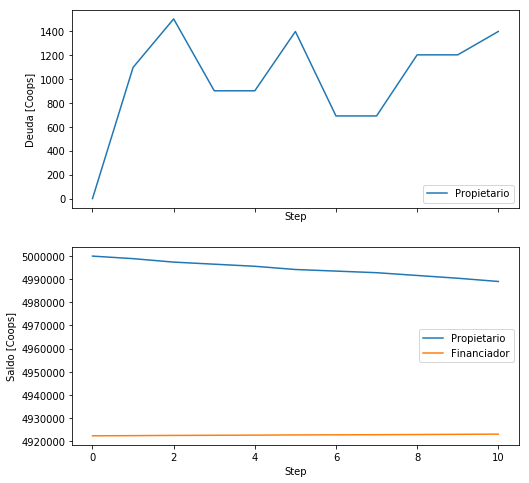

In [16]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
steps = np.linspace(0,i_steps,i_steps+1)
#plt.plot(steps,totaldebt, label='Propietario')
#plt.plot(steps,balances, label='Propietario')
# Two subplots, unpack the axes array immediately
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.set_figheight(8)
f.set_figwidth(8)
ax1.plot(steps,totaldebt, label='Propietario')
ax1.set(xlabel='Step', ylabel='Deuda [Coops]')
ax1.legend()
ax2.plot(steps,np.array(balances), label='Propietario')
ax2.plot(steps,np.array(xbalances), label='Financiador')
ax2.set(xlabel='Step', ylabel='Saldo [Coops]')
ax2.legend()

In [17]:
xbalances

[4922300,
 4922373,
 4922473,
 4922533,
 4922593,
 4922686,
 4922732,
 4922778,
 4922858,
 4922938,
 4923031]

In [18]:
'='+os.getcwd()

'=/home/renete/Downloads/memoria'